# Appendix

First, we load the python packages that we are going to use.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from patsy import dmatrix 
import seaborn as sns
import os
import smopy
import random
from sklearn.model_selection import train_test_split
from statsmodels.gam.api import GLMGam
import warnings
warnings.filterwarnings('ignore')
random.seed(615201)

Next, we load the data that we downloaded from the website.

In [2]:
data = pd.read_excel("data.xlsx")
data.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


Now, we start the basic data manipulation and analysis.

In [3]:
# drop the column "No"
data = data.drop("No", axis=1)
# check if there is NaN
data.isnull().values.any()

False

So, there is no NaN values in the dataframe

In [4]:
print(f"The dimensions of the data is {data.shape}.")
data.describe()

The dimensions of the data is (414, 7).


,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


Now, let's check the correlation between the variables.

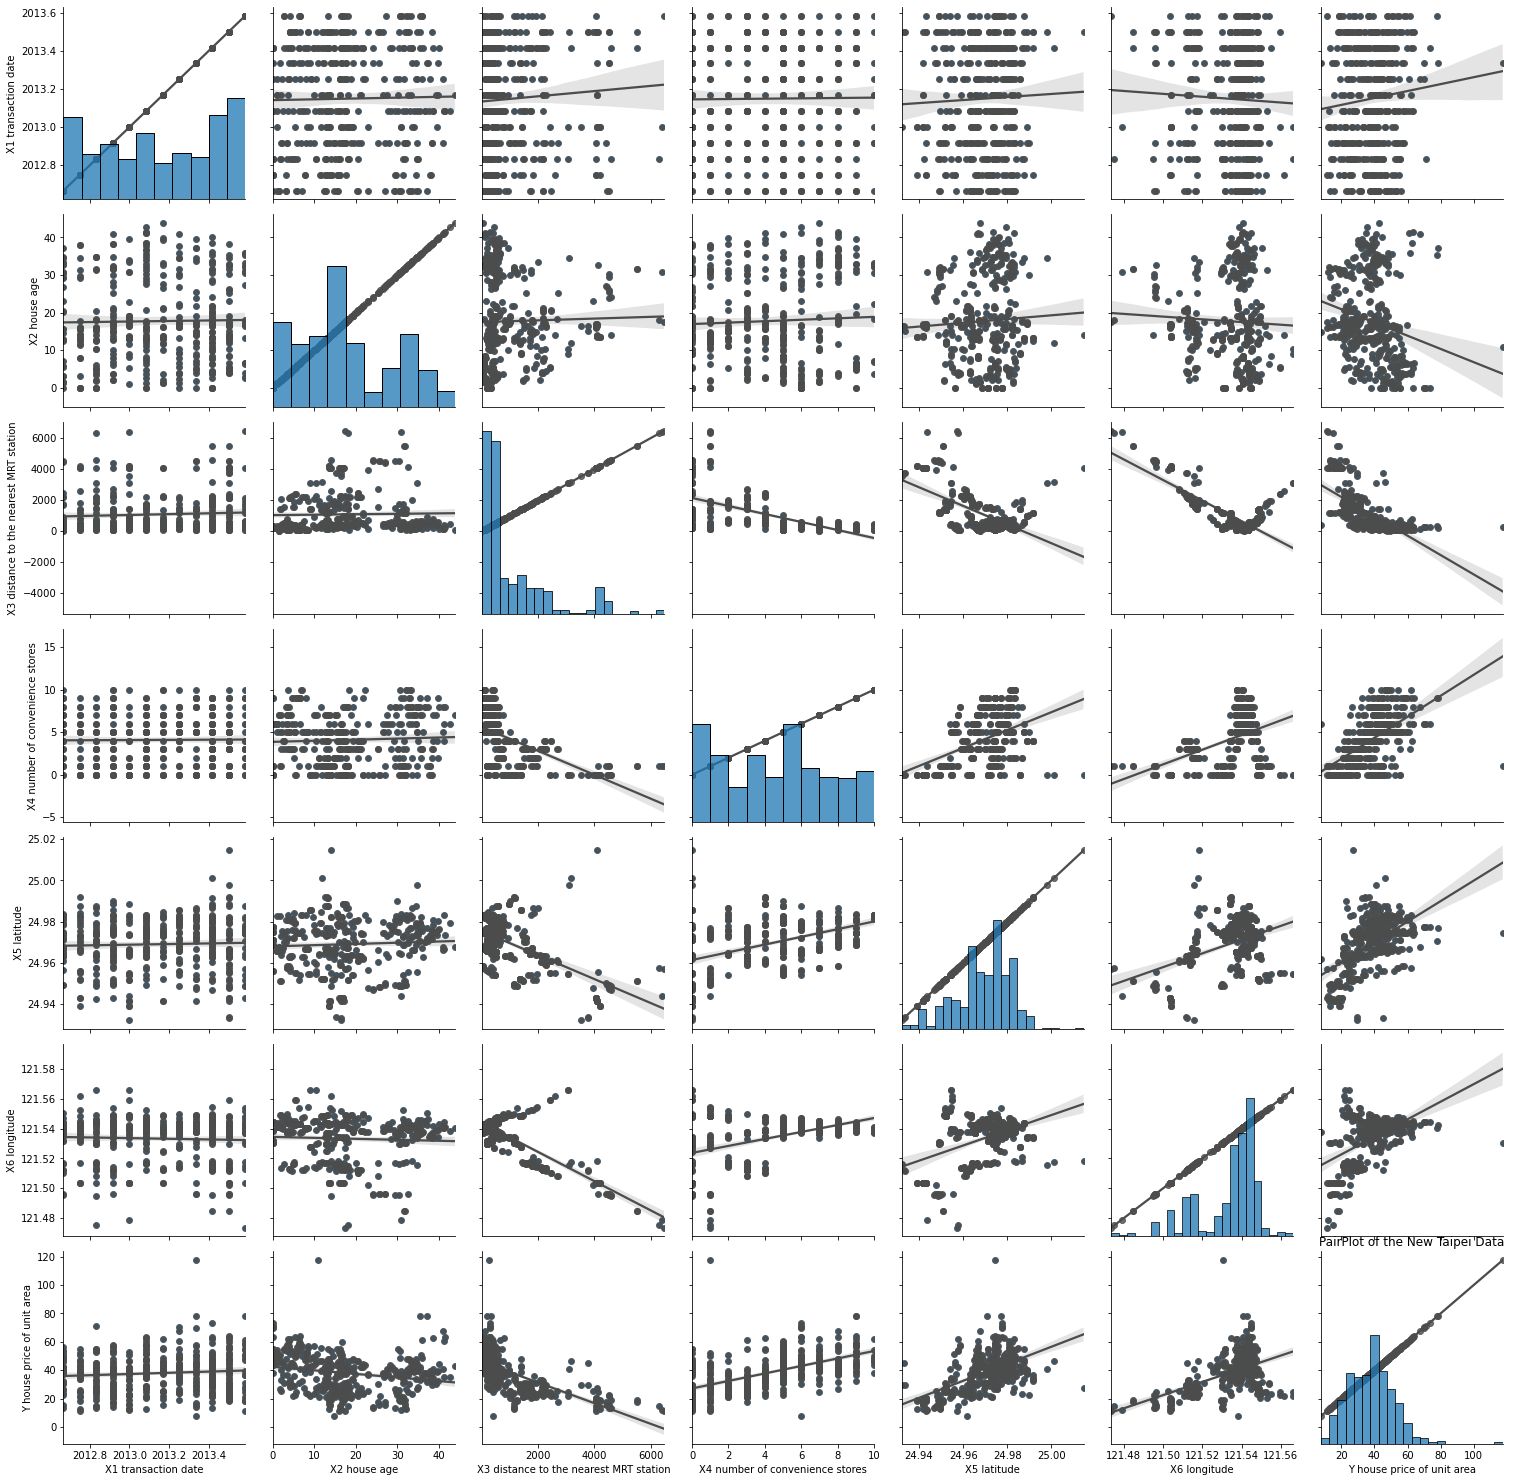

In [5]:
g = sns.PairGrid(data, height=3)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot) 
g.map(sns.regplot, color="0.3")
g.add_legend()
plt.title("PairPlot of the New Taipei Data")
plt.show()

Next, lets check the price distribution based on the map in the real life. 

In [6]:
lat_max = data["X5 latitude"].max()
lon_max = data["X6 longitude"].max()
lat_min = data["X5 latitude"].min()
lon_min = data["X6 longitude"].min()

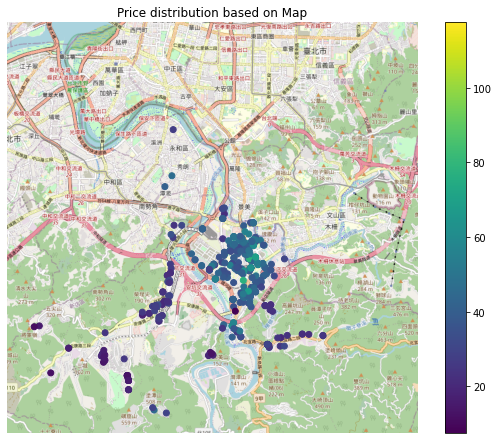

In [7]:
base = smopy.Map((lat_min+0.005, lon_min+0.005, lat_max+0.005, lon_max+0.005),z=13)
ax = base.show_mpl(figsize=(8, 6))
xl = []
yl = []
for i in range(len(data)):
    x, y = base.to_pixels(data["X5 latitude"].loc[i], data["X6 longitude"].loc[i])
    xl.append(x)
    yl.append(y)
plt.title("Price distribution based on Map")
plt.scatter(xl, yl, c=data["Y house price of unit area"])
plt.colorbar()

Now, we start the train-test split and prepare them further works.

In [8]:
# reset column names
data = data.rename(columns = {"X1 transaction date":"X1", "X2 house age":"X2", 
       "X3 distance to the nearest MRT station":"X3", "X4 number of convenience stores":"X4",
       "X5 latitude":"X5", "X6 longitude":"X6",	"Y house price of unit area":"Y"})
train, test = train_test_split(data, test_size=0.1, random_state=6150201)

Start the fitting of the forward stepwise spline and use AIC as the model selection criterion.

In [9]:
def fstep_aic(dat, outcome, fixed):
    '''
    Forward stepwise spline fitting with AIC
    input:
        dat = pandas data frame
        outcome = dependent variable name
        fixed = list of tuples to keep fixed with (var_name, df)
    output: list of models with AIC
    '''
    model_data = []
    fmla = f'{outcome}~'
    vrbls = dat.columns.to_list()
    vrbls.remove(outcome)
    fixed_var = []
    fixed_df = []
    for var in fixed:
        if var[0] in vrbls: 
            vrbls.remove(var[0])
            fmla = fmla + f'{var[0]}+'
        if var[1]>1:
            fixed_var.append(var[0])
            fixed_df.append(var[1])
    for var in vrbls:
        c_fmla = fmla + var
        if np.issubdtype(dat.dtypes[var], np.number):
            deg_free = [1,4,5,6,7]
        else:
            deg_free = [1]
        for free in deg_free:
            if any([x>1 for x in [free]+fixed_df]):
                if free>1:
                    c_vars = [var]+fixed_var
                    dfs = [free]+fixed_df
                else:
                    c_vars = fixed_var
                    dfs = fixed_df
                smoothing = sm.gam.BSplines(
                    dat[c_vars], df=dfs, 
                    degree=(len(dfs))*[3])
                model = GLMGam.from_formula(
                    c_fmla, data=dat, smoother=smoothing,
                    family=sm.families.Gaussian())
            else:
                model = sm.GLM.from_formula(
                    c_fmla, data=dat,
                    family=sm.families.Gaussian())
            results = model.fit()
            c_model = {'Spline': var, 'DF': free,
                       'AIC': round(results.aic, 2)}
            model_data.append(c_model)
        model_aic = pd.DataFrame.from_records(model_data)
    return(model_aic.sort_values(by='AIC'))

In [10]:
fixed_l = []
i = 0
while i < 6:
    data_choose = fstep_aic(train, 'Y', fixed=fixed_l)
    v = data_choose["Spline"].iloc[0]
    df = data_choose["DF"].iloc[0]
    d = (v, df)
    fixed_l.append(d)
    i += 1
data_choose

,Spline,DF,AIC
0,X4,1,2581.40
1,X4,4,2584.45
2,X4,5,2586.44
3,X4,6,2588.43
4,X4,7,2589.96


Since there is no more variable, we can stop here, and the best AIC that comes from the spline model is 2581.40.

Now, we check the GLM model.

In [11]:
fml = 'Y ~ X1 + X2 + X3 + X4 + X5 + X6' 
model_base = sm.GLM.from_formula(fml, data=train, family=sm.families.Gaussian()).fit()
print(f"The GLM model's AIC is {model_base.aic}")
model_base.summary()

The GLM model's AIC is 2690.646442599963


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      Y   No. Observations:                  372
Model:                            GLM   Df Residuals:                      365
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          79.552
Method:                          IRLS   Log-Likelihood:                -1338.3
Date:                Fri, 18 Mar 2022   Deviance:                       29036.
Time:                        21:03:19   Pearson chi2:                 2.90e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.369e+04   7167.811     -1.910      0.056   -2.77e+04     358.796
X1             5.2383      1.650      3.175      0.001       2.005       8.472
X2            -0.2789      0.041     -6.827      0.000      -0.359      -0.199
X3            -0.0046      0.001     -6.021      0.000      -0.006      -0.003
X4             1.1466      0.200      5.742      0.000       0.755       1.538
X5           212.4165     48.280      4.400      0.000     117.790     307.043
X6           -17.4144     51.376     -0.339      0.735    -118.110      83.281
==============================================================================
"""

Now, we check the intercept model.

In [12]:
incpt_model = sm.GLM.from_formula('Y ~ 1', data=train, 
family=sm.families.Gaussian()).fit()
print(f"Intercept Model, AIC: {np.round(incpt_model.aic,2)}")

Intercept Model, AIC: 3004.52


So, based on the AIC criterion, the spline model has a better ﬁt on here than either the (linear) GLM and the intercept model.

Now, we start to check and evaluate the spline model we got.

In [13]:
# get the degree of freedom of each variable
fixed_l

[('X3', 7), ('X5', 5), ('X2', 5), ('X1', 1), ('X6', 4), ('X4', 1)]

In [14]:
fmla = 'Y ~ X1 + bs(X2, 4) + bs(X3, 6) + X4 + bs(X5, 4) + bs(X6, 3)'
fsw_model = sm.GLM.from_formula(fmla, data=train, family=sm.families.Gaussian()) 
fsw_results = fsw_model.fit()
vrbls = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']

In [15]:
def get_median_mode(dat, num):
    d_mat = {}
    for var in vrbls:
        if np.issubdtype(dat[var].dtype, np.number): 
            d_mat[var] = dat[var].median()
        else:
            d_mat[var] = dat[var].mode()
    d_mat = pd.DataFrame([d_mat], columns = d_mat.keys())
    return(sm.add_constant(pd.concat([d_mat]*num)))

def plot_spline(var, plt, fsw_results, dat):
    if np.issubdtype(dat[var].dtype, np.number): 
        num = 500
        d_mat = get_median_mode(dat, num)
        d_mat[var] = np.linspace(dat[var].min(), dat[var].max(), num) 
        y = fsw_results.predict(exog = d_mat)
        plt.plot(d_mat[var], y) 
    else:
        d_mat = get_median_mode(dat, dat[var].nunique()) 
        d_mat[var] = dat[var].unique()
        y = fsw_results.predict(exog = d_mat) 
        plt.bar(d_mat[var], y)
    plt.set(xlabel=var, ylabel='Price of the house')

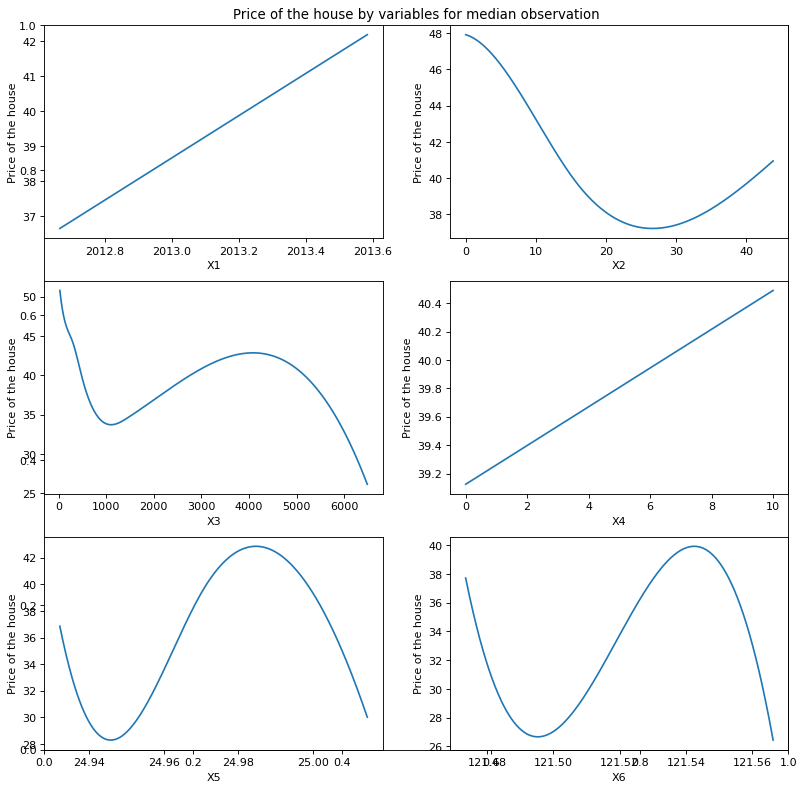

In [16]:
fig=plt.figure(figsize=(12, 12), dpi=80)
plt.title(f'Price of the house by variables for median observation') 
for itr, var in enumerate(vrbls):
    ax=fig.add_subplot(3, 2, itr+1)
    plot_spline(var, ax, fsw_results, train)

Here we plotting splines as prices, each plot holds all other variable median values constant while varying one variable. In this way we can have an overall view of how each variable influence the price of the house. 

Here each variable stands for:

* "X1 transaction date":"X1"
* "X2 house age":"X2", 
* "X3 distance to the nearest MRT station":"X3"
* "X4 number of convenience stores":"X4"
* "X5 latitude":"X5"
* "X6 longitude":"X6"

So, here, we can see that:

* Both longitude and latitude have a shape of convex, this means in the middle of the area include, the price is higher. This result consist with the result from the map plot.
* Both transection date and number of conveniece stores are positively correlated with the price of the house.
* For house age, the U-shape can be intepreted as the linear shape. So the Price of the house will decreas with the age of the house.
* It seems that the price of the house are negatively correlated with the distance to the MRT station in general.

Next, we test the prediction power of the model.

In [17]:
real_test = list(test["Y"])
test_input = test.drop("Y", axis=1)

In [18]:
prediction_list = []
count = 0
for i in range(len(test)):
    input = dict(test_input.iloc[i])
    pred = fsw_results.predict(input).values[0]
    prediction_list.append(pred)

First, we check about the MSE of our spline model.

In [19]:
from sklearn.metrics import mean_squared_error
import math
print(mean_squared_error(real_test, prediction_list))

47.01749877908336


Check the MSE of the GLM model.

In [20]:
pred_list = []
count = 0
for i in range(len(test)):
    input = dict(test_input.iloc[i])
    pred = model_base.predict(input).values[0]
    pred_list.append(pred)

In [21]:
print(mean_squared_error(real_test, pred_list))

69.49220810125891


We can use the plot to check the prediction result of the model.

Based on the MSEs of our two models, 47.01 < 69.49, we have again confirmed that our spline model is better than the GLM model.

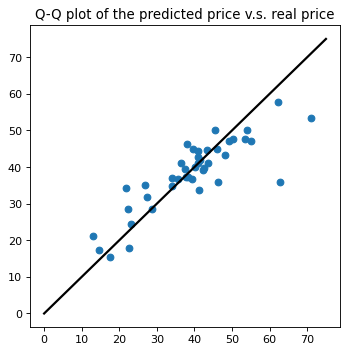

In [22]:
fig=plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(real_test, prediction_list)
plt.plot([0,75], [0,75], color = 'black', linewidth = 2)
plt.title("Q-Q plot of the predicted price v.s. real price")
plt.show()

Based on the QQ plot, we can have that the prediction v.s. the real value in our test data set basicly lies on the 45 degree line of the QQ plot, so our model did a great job in the predction task.

Here is the prediction example:

In [23]:
# new data input
housing_info = {'X1': 2013.3333333,
                'X2': 19.2,
                'X3': 383.7129,
                'X4': 8.0,
                'X5': 24.972,
                'X6': 121.54477}
expexted_cost = fsw_results.predict(input).values[0]
print(f"The expected cost of the new give housing information is {expexted_cost}.")

The expected cost of the new give housing information is 33.86411998479687.
